##### 12/18/24 
### Notebook to align node embeddings from Progres

##### Import packages, change kernel to prog

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os

/home/ubuntu/miniforge3/envs/prog/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import progres as pg

/home/ubuntu/miniforge3/envs/prog/lib/python3.9/site-packages/progres/trained_models/v_0_2_0/trained_model.pt


### Set model: CIRPIN or Progres

In [40]:

def set_model(model_name):
    ''' Loaded CIRPIN or Progres models 
    Returns two models, one that returns average embedding, other returns node level embs'''
    if model_name == 'CIRPIN':
        fp = '/home/ubuntu/CIRPIN/trained_models/CIRPIN_model/CIRPIN_model_5k_cp_epoch301.pt'
    elif model_name == 'Progres':
        fp = '/home/ubuntu/CIRPIN/trained_models/Progres_model/Progres_trained_model.pt'

    model_loaded = pg.load_trained_model(trained_model=fp)
    model_loaded_nodes = pg.load_trained_model(trained_model=fp, return_feats=True)
    
    return model_loaded, model_loaded_nodes


In [107]:
model_name = 'CIRPIN'
model_loaded, model_loaded_nodes= set_model(model)

Using model CIRPIN_model_5k_cp_epoch301.pt
Using model CIRPIN_model_5k_cp_epoch301.pt


In [43]:
def permutate_coords(coords, i):
    '''Takes coordinates from progres and permutes them i positions '''
    coords = torch.tensor(coords)
    coords_cp = torch.roll(coords, i, 0)
    return coords_cp

##### Set query and target pdbs

In [105]:
query = 'd2z9ia1.pdb'
target = 'd2hgaa1.pdb'
path = '/home/ubuntu/scope40/pdbstyle-2.08'

query_path = os.path.join(path, query)
target_path = os.path.join(path, target)

##### Get the embedding of the nodes

In [106]:
##### Get the progres graph of a pdb file

coords_query = pg.read_coords(query_path)
graph_query = pg.coords_to_graph(coords_query, '')

coords_target = pg.read_coords(target_path)
graph_target = pg.coords_to_graph(coords_target, '')

##### Get the embedding of the graph

#%%capture
# use to suppress outputs
 
query_emb = pg.embed_graph(graph_query, return_feats=False, model=model_loaded)
target_emb = pg.embed_graph(graph_target, return_feats=False, model=model_loaded)

##### Get the embedding of the nodes

query_emb_nodes = pg.embed_nodes(graph_query, model=model_loaded_nodes)
target_emb_nodes = pg.embed_nodes(graph_target, model=model_loaded_nodes)
# check shape
print(target_emb_nodes.shape)
print(query_emb_nodes.shape)

torch.Size([103, 128])
torch.Size([87, 128])


##### Get embedding of circular permutations of query and target nodes

In [95]:
# Choose which permutation by setting i and j for query and target respectively
i= 0

coords_query_cp = permutate_coords(coords_query, i)
graph_query_cp = pg.coords_to_graph(coords_query_cp, '')
query_emb_nodes_cp = pg.embed_nodes(graph_query_cp, model=model_loaded_nodes)

j = 0

coords_target_cp = permutate_coords(coords_target, j)
graph_target_cp = pg.coords_to_graph(coords_target_cp, '')
target_emb_nodes_cp = pg.embed_nodes(graph_target_cp, model=model_loaded_nodes)

##### Get score between two CP graphs

In [96]:
query_emb_cp = pg.embed_graph(graph_query_cp, return_feats=False, model=model_loaded)
target_emb_cp = pg.embed_graph(graph_target_cp, return_feats=False, model=model_loaded)
pg.embedding_similarity(query_emb_cp,target_emb_cp)

tensor(0.9901)

##### Turn the node embedding tensors to a list

In [97]:
target_emb_nodes_list = target_emb_nodes[:]
query_emb_nodes_list = query_emb_nodes[:]
query_emb_nodes_cp_list = query_emb_nodes_cp[:]
target_emb_nodes_cp_list = target_emb_nodes_cp[:]

##### Compare similarity between two node embeddings using cosine similarity

In [99]:
similarity = float(pg.node_embedding_similarity(query_emb_nodes_list[0], target_emb_nodes_list[0]))
similarity

0.6356210112571716

##### Get all v all scores of all  node embeddings between a query and target

In [100]:
# Dictionary of scores; value is the score, key is the query/target node pair that yielded the score.
all_v_all_scores_dict = {}

# Modify which lists you are comparing embeddings between
query_list = query_emb_nodes_cp_list
target_list = target_emb_nodes_cp_list

q = 0
for query_node in query_list:
    t = 0
    for target_node in target_list:
        all_v_all_scores_dict[(q,t)] = float(pg.node_embedding_similarity(query_node,target_node))
        t+=1
    q+=1


# Save scores of the dictionary to a list
all_v_all_scores = list(all_v_all_scores_dict.values())


In [101]:
scores_matrix = np.array(all_v_all_scores).reshape(len(query_list), len(target_list))

#### Plot the similarity matrix

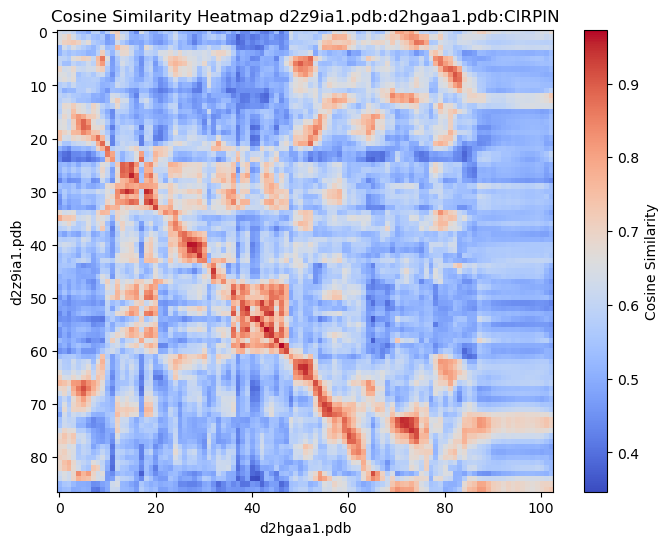

In [102]:

# Plotting the heatmap using Matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(scores_matrix, cmap='coolwarm', aspect='auto')

# Add colorbar
cbar = plt.colorbar()
cbar.set_label('Cosine Similarity')

# Add labels and title
plt.title(f"Cosine Similarity Heatmap {query}:{target}:{model}")
plt.xlabel(f'{target}')
plt.ylabel(f'{query}')

#plt.savefig(f'sim_mat_{model_name}.png', format='png', dpi=300, bbox_inches='tight', transparent=True)  # Saves as a PNG file


### Apply argmax to the similarity matrix

In [103]:
column_argmax = np.argmax(scores_matrix, axis=0)

# Create a mask with the same shape as the array, filled with 0s
result = np.zeros_like(scores_matrix)

# Set the maximum values to 1
result[column_argmax, np.arange(scores_matrix.shape[1])] = 1


### Plot argmax(similarity matrix)

Text(0, 0.5, 'd2z9ia1.pdb')

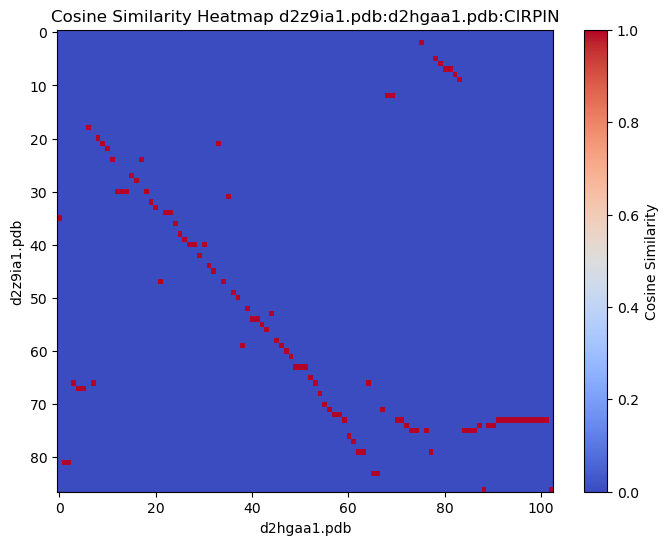

In [104]:
plt.figure(figsize=(8, 6))
plt.imshow(result, cmap='coolwarm', aspect='auto')

# Add colorbar
cbar = plt.colorbar()
cbar.set_label('Cosine Similarity')

# Add labels and title
plt.title(f"Cosine Similarity Heatmap {query}:{target}:{model}")
plt.xlabel(f'{target}')
plt.ylabel(f'{query}')